**KUDAGO categories relation**

Goal - to estimate relations between different kudago categories.

to do: adjust delimiter for tags, ARL


In [9]:
#connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#read dataset
import pandas as pd
DATA0 = pd.read_csv("/content/drive/My Drive/Multi-scale events detection/kudago/403-497_clean.csv", delimiter=';', encoding='cp1251', error_bad_lines=False)
DATA1 = pd.read_csv("/content/drive/My Drive/Multi-scale events detection/kudago/1-402_clean.csv", delimiter=';', encoding='cp1251', error_bad_lines=False)
DATA2 = pd.read_csv("/content/drive/My Drive/Multi-scale events detection/kudago/497-1653_clean.csv", delimiter=';', encoding='cp1251', error_bad_lines=False)
DATA = pd.concat([DATA0,DATA1,DATA2])

In [11]:
print('Events amount', DATA.shape[0])

Events amount 165565


#First step: analyzing event tags



# Preprocessing

In [12]:
#cut the table
df = DATA[['Category', 'Event tag']]

In [13]:
#checking what kind of categories we have
df.groupby(['Category']).count()


,Event tag
Category,
business-events,476
"business-events,entertainment",6
"business-events,festival",17
"business-events,festival,entertainment",1
"business-events,festival,recreation",1
...,...
"tour,recreation,entertainment",5
"tour,yarmarki-razvlecheniya-yarmarki,entertainment",3
yarmarki-razvlecheniya-yarmarki,5


Firstly, let's not use events of multiple categories


In [14]:
#checking how many events we have for each category
df_new = df[~df['Category'].str.contains(',', na=False)]
df_new.groupby(['Category']).count()

,Event tag
Category,
business-events,476
cinema,106
concert,56347
education,10641
entertainment,2625
exhibition,15125
fashion,125
festival,4040
holiday,835


In [15]:
#concatenation of all tags for each category
df_grouped_full = df_new.groupby(['Category']).apply(lambda x: ','.join(x['Event tag']))

In [16]:
#here we remove categories of kudago, which we will not use for events detecting task
deleted_cats =  ['quest', 'yarmarki-razvlecheniya-yarmarki','other','stock']
df_grouped = df_grouped_full.drop(deleted_cats, axis=0)
df_grouped

Category
business-events    12+,события для бизнеса,события для бизнеса,со...
cinema             кинопоказы,12+,кино (развлечения),кино (развле...
concert            рэп и хип-хоп,концерты,16+,концерты,альтернати...
education          обучение,16+,лучшее,искусство,обучение,12+,рис...
entertainment      игры,развлечения,16+,шоу,лучшее в театрах,разв...
exhibition         выставки,картины, живопись, графика,выставки,к...
fashion            мода и стиль,шоурумы,красота и здоровье,тренин...
festival           фестивали,городские,free,культура и искусство,...
holiday            животные,тематические праздники,выходные,празд...
kids               12+,детские лагеря,лучшее в мае,детям,детские ...
party              18+,танцевальная,вечеринки,электронная музыка,...
photo              животные,фотография,интересное,всей семьей,fre...
recreation         отдых,18+,спорт и фитнес,хоккей,6+,отдых,отдых...
shopping           шопинг (магазины),free,шопинг (магазины),книги...
social-activity    благот

#Summary Table Creation

In [17]:
#the next cell is very time expensive, we check if we have a file with it
import os
check_file = False
if os.path.exists('/content/drive/My Drive/Colab Notebooks/kudago_tags.pkl'):
  check_file = True
  df_final = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/kudago_tags.pkl')
check_file

True

In [18]:
#We want to know which tags (rows) were used for which categories (columns) and how many times (data in cells)
#To do it we create DataFrame from the dict of subdicts: one subdict for one category, each subdict maps tag to number of tag's usages 
if check_file == False:
  dict_lists = dict()
  for index in df_grouped.index:
    temp = df_grouped.get(index).rsplit(',')
    one_dict = {i:temp.count(i) for i in temp}
    dict_lists[index]=(one_dict)
  #final statistics DataFrame
  df_final = pd.DataFrame(dict_lists).fillna(0)
else:
  print('File was found')

File was found


In [19]:
df_final

,business-events,cinema,concert,education,entertainment,exhibition,fashion,festival,holiday,kids,party,photo,recreation,shopping,social-activity,theater,tour
12+,12.0,10.0,10786.0,1526.0,207.0,971.0,4.0,283.0,15.0,36.0,22.0,1.0,210.0,0.0,3.0,3661.0,602.0
события для бизнеса,476.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18+,167.0,67.0,14700.0,1932.0,556.0,401.0,11.0,427.0,39.0,0.0,3527.0,3.0,176.0,0.0,19.0,1978.0,150.0
free,135.0,29.0,2594.0,2681.0,356.0,4051.0,29.0,1653.0,315.0,122.0,1177.0,12.0,348.0,42.0,81.0,435.0,164.0
16+,70.0,11.0,11108.0,2094.0,286.0,454.0,14.0,303.0,9.0,0.0,123.0,0.0,128.0,4.0,7.0,5364.0,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
погода,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
эзотерика,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
блошиные рынки,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ярмарки (развлечения,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#save dataframe to file
if check_file == False:
  df_final.to_pickle("/content/drive/My Drive/Colab Notebooks/kudago_tags.pkl")
else:
  print('File exists')

File exists


#Supervenn visualisation for non-unique tags


In [21]:
#visualize data with method from https://habr.com/ru/company/yandex/blog/501924/
!pip install supervenn

In [22]:
#labels are categories
labels = list(df_final.columns)
#sets are tags
sets = []
for index in df_grouped.index:
  temp = df_grouped.get(index).rsplit(',')
  sets.append(set(temp))

In [23]:
#to find intersections of categories we don't consider unique tags
new_sets = []
for i in range(len(sets)):
  temp_list = []
  for j in range(len(sets)):
    #avoiding comparing with the same set
    if i == j:
      continue
    #we collect not unique tags into list
    temp_list.extend(sets[i] & sets[j])
  #now we need to convert our collection to set
  new_sets.append(set(temp_list))

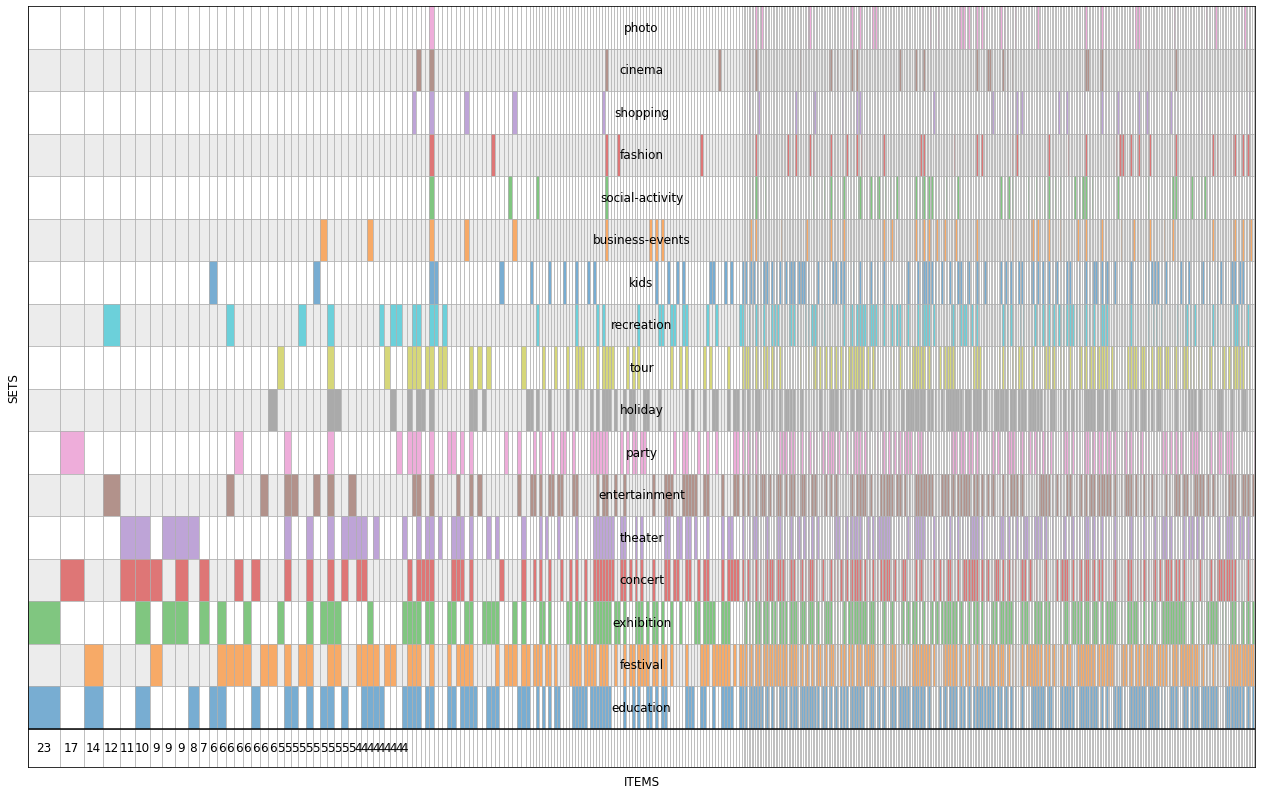

In [24]:
import matplotlib.pyplot as plt
from supervenn import supervenn
plt.figure(figsize=(22, 14))
visual0 = supervenn(new_sets, labels, side_plots=False, chunks_ordering='size', sets_ordering='size', widths_minmax_ratio=0.05, min_width_for_annotation=4)

# Supervenn visualisation without frequent tags

Results are good, but not so clean, let's firstly delete very frequent tags (appears more than in 5 categories)

In [25]:
#here we check in how many categories the particular tag appears, and delete very frequent tags
import copy
new_sets_cut = copy.deepcopy(new_sets)

#for all sets
for i in range(len(new_sets)):
  #check all tags
  for j in new_sets[i]:
    counter = 0
    #check for all other sets except the same one
    for k in range(len(new_sets)):
      if k == i:
        continue
      if j in new_sets[k]:
        counter += 1
    if counter > 5:
      new_sets_cut[i].remove(j)

In [26]:
#amount of unique/not unique tags
print('unique\t common\t total')
for i in range(len(new_sets_cut)):
  print('{}\t :{}\t  :{}\t :{}'.format(len(sets[i])-len(new_sets[i]), len(new_sets[i]), len(sets[i]), labels[i]))

unique	 common	 total
1	 :62	  :63	 :business-events
2	 :35	  :37	 :cinema
47	 :347	  :394	 :concert
41	 :454	  :495	 :education
21	 :300	  :321	 :entertainment
37	 :404	  :441	 :exhibition
3	 :47	  :50	 :fashion
28	 :443	  :471	 :festival
5	 :240	  :245	 :holiday
11	 :148	  :159	 :kids
16	 :243	  :259	 :party
0	 :30	  :30	 :photo
40	 :182	  :222	 :recreation
2	 :41	  :43	 :shopping
3	 :56	  :59	 :social-activity
50	 :301	  :351	 :theater
20	 :205	  :225	 :tour


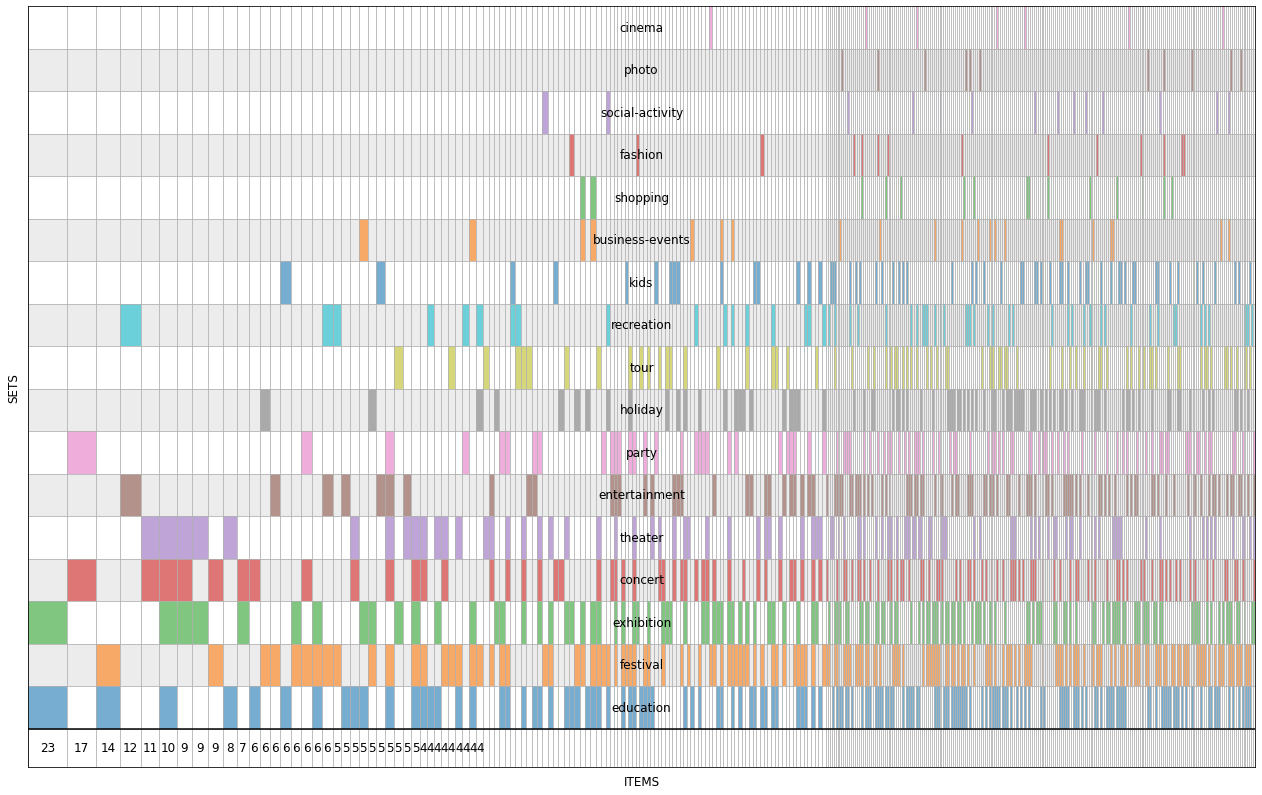

In [27]:
plt.figure(figsize=(22, 14))
visual = supervenn(new_sets_cut, labels, side_plots=False, chunks_ordering='size', sets_ordering='size', widths_minmax_ratio=0.05, min_width_for_annotation=4)

In [28]:
#example of extracting common tags
print(visual.chunks[frozenset([labels.index('education'), labels.index('exhibition')])])
print(visual.chunks[frozenset([labels.index('party'), labels.index('concert')])])

{'cобаки', 'бижутерия', 'мэрилин монро', 'концептуальное искусство', 'декупаж', 'абстрактное искусство', 'голландия', 'будущее', 'витражи', 'bibliophilia', 'скрапбукинг', 'гравюра', 'изобретения', 'акварель', 'аналоговая фотография', 'архитектура', 'мозаика', 'арт-объекты', 'александр васильев', 'обучение за рубежом', 'парфюмерия', 'эпоха возрождения', 'батик'}
{'r&b', 'рейв', 'witch house', 'диско', 'эмбиент', 'дискотека 80х', 'хардкор техно', 'тяжелый рок', 'душевно', 'дискотека 90х', 'виниловые пластинки', 'драм-н-бэйс', 'день первокурсника', 'клубная жизнь', 'rnb', 'майкл джексон', 'glitch'}


#Second step: analyzing events of multiple categories

Here we want to analyze which categories have common events (by extracting events with multiple categories)

In [29]:
df_multiple =  df[df['Category'].str.contains(',', na=False)]
print('Amount of events with multiple categories', df_multiple.shape[0])

Amount of events with multiple categories 41354


In [30]:
#we create an array of two dims and remeber how many times each category was with another one
n = len(df_grouped_full.index)
group_list = list(df_grouped_full.index)
cats_inter = [[0] * n for i in range(n)]
for event in df_multiple['Category']:
  cats = event.rsplit(',')
  for i in range(len(cats)):
    for j in range(len(cats)):
      if i != j:
        cats_inter[group_list.index(cats[j])][group_list.index(cats[i])] += 1

In [31]:
df_step2 = pd.DataFrame(cats_inter, columns=group_list, index=group_list).fillna(0)
df_step2 = df_step2.drop(labels=deleted_cats, axis=0)
df_step2 = df_step2.drop(labels=deleted_cats, axis=1)
df_step2

,business-events,cinema,concert,education,entertainment,exhibition,fashion,festival,holiday,kids,party,photo,recreation,shopping,social-activity,theater,tour
business-events,0,0,4,682,29,72,6,51,0,9,2,1,6,1,2,0,1
cinema,0,0,143,683,5634,78,15,1139,60,165,344,3,19,2,26,194,21
concert,4,143,0,1110,1809,137,13,2488,354,1119,1917,5,166,14,288,1111,57
education,682,683,1110,0,1943,674,551,1276,434,2233,476,117,697,58,226,540,368
entertainment,29,5634,1809,1943,0,905,152,3067,977,2147,1229,59,897,272,334,1220,280
exhibition,72,78,137,674,905,0,173,636,97,744,88,447,45,38,182,67,261
fashion,6,15,13,551,152,173,0,93,29,21,40,21,13,91,11,8,2
festival,51,1139,2488,1276,3067,636,93,0,875,1546,674,61,649,44,362,521,174
holiday,0,60,354,434,977,97,29,875,0,1296,687,19,194,57,75,308,126
kids,9,165,1119,2233,2147,744,21,1546,1296,0,154,31,375,34,237,4253,498


We can see a number of events with common categories, but the table does not include total number of events for each category. In other words, if only 1 event of "shopping" out of 1000 is also marked as "business-event" it shows very weak correlation, however, if we have the same result with 1 event of "shopping" out of 2 events it is interesting to know.

In [32]:
#here we transform our table from 'number' to 'percentege' by taking into account a total number of events for each category
#we divide each column by the number of events and multiply 100 to find a percentege
for cat in df_step2.index:
  count = df[df['Category'].str.contains(cat, na=False)].count()[0]
  df_step2[cat] = df_step2[cat].apply(lambda x: x/count*100)

In [33]:
#let's highlight large percentege values to see the results better
def style_large_values(v, props=''):
    return props if v > 30 else None
s2 = df_step2.style.applymap(style_large_values, props='color:red;')\
              .applymap(lambda v: 'opacity: 20%;' if (v < 5) else None)
s2

,business-events,cinema,concert,education,entertainment,exhibition,fashion,festival,holiday,kids,party,photo,recreation,shopping,social-activity,theater,tour
business-events,0.000000,0.000000,0.006132,3.461578,0.152768,0.384656,0.561272,0.380370,0.000000,0.074044,0.022696,0.138504,0.127578,0.142248,0.129702,0.000000,0.023602
cinema,0.000000,0.000000,0.219214,3.466653,29.679187,0.416711,1.403181,8.494928,1.355932,1.357466,3.903768,0.415512,0.403997,0.284495,1.686122,0.931573,0.495634
concert,0.314713,2.473620,0.000000,5.633946,9.529579,0.731916,1.216090,18.556086,8.000000,9.206088,21.754426,0.692521,3.529662,1.991465,18.677043,5.334934,1.345291
education,53.658537,11.814565,1.701593,0.000000,10.235474,3.600812,51.543499,9.516706,9.807910,18.371041,5.401725,16.204986,14.820327,8.250356,14.656291,2.593037,8.685391
entertainment,2.281668,97.457187,2.773136,9.861943,0.000000,4.834918,14.218896,22.874403,22.079096,17.663513,13.946891,8.171745,19.072932,38.691323,21.660182,5.858343,6.608449
exhibition,5.664831,1.349248,0.210016,3.420972,4.767423,0.000000,16.183349,4.743437,2.192090,6.120938,0.998638,61.911357,0.956836,5.405405,11.802853,0.321729,6.160019
fashion,0.472069,0.259471,0.019929,2.796670,0.800716,0.924244,0.000000,0.693616,0.655367,0.172768,0.453926,2.908587,0.276419,12.944523,0.713359,0.038415,0.047203
festival,4.012589,19.702474,3.814021,6.476500,16.156561,3.397799,8.699719,0.000000,19.774011,12.719046,7.648661,8.448753,13.799702,6.258890,23.476005,2.501801,4.106679
holiday,0.000000,1.037883,0.542670,2.202822,5.146710,0.518218,2.712816,6.525955,0.000000,10.662279,7.796187,2.631579,4.125027,8.108108,4.863813,1.478992,2.973802
kids,0.708104,2.854177,1.715389,11.333875,11.310120,3.974784,1.964453,11.530430,29.288136,0.000000,1.747617,4.293629,7.973634,4.836415,15.369650,20.422569,11.753599


Now we can easily find some trends:
*   53% events of 'business-events' are also 'education'
*   97% events of 'cinema' are also 'entertainment'
*   61% events of 'photos' are also 'exhibition'
*   and so on.. 

# Third step: Associations rules learning analyzes

ARL basics: one have a collection D = [d_{1}, d_{2}, ..., d_{n}], where d_{i} is a unique transaction-itemset. There are items inside of the each d_{i}, which are represented in binary view. Usually each d_{i} is described with non-zero values (k-itemset). As a result of ARL algorithm applying one can have a rules that represents information about corelation between different items.

In our case we want to find a correlation between tags and categories. But as far as we also have another entity - events, we have some freedom in formulating of ARL problem in terms of event detection task. We can perform two analyzes: the small one (category-level) and the big one (event-level). The difference between two analyzes is in choosing of transaction definition.

For the **category-level** analysis we will find a set of tags for each category, then we will consider category as a transaction (itemset) and each tag as an item. This approach will allow us to find which tags are usually appear in different categories together. The number of transaction in this analysis is equal to the number of categories, that's why it is small one.

We can divide this level in two subanalysis, the one for which we will not use events of multiple categories and the opposite one. From one point of view, tags of events with common categories will appear in different categories and affect result, so it will be more difficult to find hidden correlations of the dataset. From the other point of view it can provide additional information and as a result leads to more unexpected results.

*As I expect results of this analysis should give us the similar picture as for supervenn, but in more general way, because supervenn represents only correlations with 100% condfidence (only common tags), here we will obtain also tags which are used together with some probability lower than 1.*

For the **event-level** analysis we will consider each event as a transaction and corresponding group of tags as items. This analysis will give us more precise information about correlations of tags which are used in different events. In this analysis we do not take into account categories at all.

In [41]:
#ARL analysis https://habr.com/ru/company/ods/blog/353502/
#!pip install apyori - does not work. Out of memory for our data...
#import apyori

In [40]:
#category-level analysis
#to begin with we need a list of categories with corresponding tags, we have already obtained this information.
#df-final contains the table with categories and corresponding tags with the number of appearances, let's create a transactoin matrix

In [ ]:
#transactions - lists of transactions
transactions = []
for i in range(0, df_final.shape[1]):
  col = df_final.iloc[:,i]
  transactions.append([str(col.keys()[j]) for j in range(df_final.shape[0]) if col[j] != 0])

In [50]:
#transaction_datased - dataset from list of transactions
data = [[df_final.keys()[i],transactions[i]] for i in range(len(transactions))]
transaction_datased = pd.DataFrame(data, columns=['trans', 'item'])
transaction_datased

,trans,item
0,business-events,"[12+, события для бизнеса, 18+, free, 16+, биз..."
1,cinema,"[12+, 18+, free, 16+, новое на сайте, лекции и..."
2,concert,"[12+, 18+, free, 16+, новое на сайте, лучшее, ..."
3,education,"[12+, 18+, free, 16+, бизнес-образование, ново..."
4,entertainment,"[12+, 18+, free, 16+, новое на сайте, лучшее, ..."
5,exhibition,"[12+, 18+, free, 16+, бизнес-образование, ново..."
6,fashion,"[12+, 18+, free, 16+, новое на сайте, лучшее, ..."
7,festival,"[12+, 18+, free, 16+, новое на сайте, лучшее, ..."
8,holiday,"[12+, 18+, free, 16+, новое на сайте, естестве..."
9,kids,"[12+, free, новое на сайте, лучшее, естественн..."


In [54]:
#using ECLAT algorithm 
import numpy as np
"""
Класс инициируется 3мя параметрами:
- min_supp - минимальный support  который мы рассматриваем для ItemSet. Рассчитывается как % от количества транзакций
- max_items - максимальное количество елементов в нашем ItemSet
- min_items - минимальное количество элементов ItemSet
"""
class Eclat:
    #инициализация объекта класса
    def __init__(self, min_support = 0.01, max_items = 5, min_items = 2):
        self.min_support = min_support
        self.max_items = max_items
        self.min_items = min_items
        self.item_lst = list()
        self.item_len = 0
        self.item_dict = dict()
        self.final_dict = dict()
        self.data_size = 0
    
    #создание словаря из ненулевых объектов из всех транзакций (вертикальный датасет)
    def read_data(self, dataset):
        for index, row in dataset.iterrows():
            row_wo_na = set(row[0])
            for item in row_wo_na:
                item = item.strip()
                if item in self.item_dict:
                    self.item_dict[item][0] += 1
                else:
                    self.item_dict.setdefault(item, []).append(1)
                self.item_dict[item].append(index)
        #задаем переменные экземпляра (instance variables)
        self.data_size = dataset.shape[0]
        self.item_lst = list(self.item_dict.keys())
        self.item_len = len(self.item_lst)
        self.min_support = self.min_support * self.data_size
        #print ("min_supp", self.min_support)
        
    #рекурсивный метод для поиска всех ItemSet по алгоритму Eclat
    #структура данных: {Item: [Supp number, tid1, tid2, tid3, ...]}
    def recur_eclat(self, item_name, tids_array, minsupp, num_items, k_start):
        if tids_array[0] >= minsupp and num_items <= self.max_items:
            for k in range(k_start+1, self.item_len):
                if self.item_dict[self.item_lst[k]][0] >= minsupp:
                    new_item = item_name + " | " + self.item_lst[k]
                    new_tids = np.intersect1d(tids_array[1:], self.item_dict[self.item_lst[k]][1:])
                    new_tids_size = new_tids.size
                    new_tids = np.insert(new_tids, 0, new_tids_size)
                    if new_tids_size >= minsupp:
                        if num_items >= self.min_items: self.final_dict.update({new_item: new_tids})
                        self.recur_eclat(new_item, new_tids, minsupp, num_items+1, k)
    
    #последовательный вызов функций определенных выше
    def fit(self, dataset):
        i = 0
        self.read_data(dataset)
        for w in self.item_lst:
            self.recur_eclat(w, self.item_dict[w], self.min_support, 2, i)
            i+=1
        return self
        
    #вывод в форме словаря {ItemSet: support(ItemSet)}
    def transform(self):
        return {k: "{0:.4f}%".format((v[0]+0.0)/self.data_size*100) for k, v in self.final_dict.items()}

In [55]:
model = Eclat(min_support = 0.01, max_items = 4, min_items = 3)

In [56]:
model.fit(transaction_datased)

In [57]:
model.transform()

{'b | v | s': '5.8824%',
 'b | v | s | e': '5.8824%',
 'b | v | s | -': '5.8824%',
 'b | v | s | u': '5.8824%',
 'b | v | s | i': '5.8824%',
 'b | v | s | t': '5.8824%',
 'b | v | s | n': '5.8824%',
 'b | v | e': '5.8824%',
 'b | v | e | -': '5.8824%',
 'b | v | e | u': '5.8824%',
 'b | v | e | i': '5.8824%',
 'b | v | e | t': '5.8824%',
 'b | v | e | n': '5.8824%',
 'b | v | -': '5.8824%',
 'b | v | - | u': '5.8824%',
 'b | v | - | i': '5.8824%',
 'b | v | - | t': '5.8824%',
 'b | v | - | n': '5.8824%',
 'b | v | u': '5.8824%',
 'b | v | u | i': '5.8824%',
 'b | v | u | t': '5.8824%',
 'b | v | u | n': '5.8824%',
 'b | v | i': '5.8824%',
 'b | v | i | t': '5.8824%',
 'b | v | i | n': '5.8824%',
 'b | v | t': '5.8824%',
 'b | v | t | n': '5.8824%',
 'b | v | n': '5.8824%',
 'b | s | e': '5.8824%',
 'b | s | e | -': '5.8824%',
 'b | s | e | u': '5.8824%',
 'b | s | e | i': '5.8824%',
 'b | s | e | t': '5.8824%',
 'b | s | e | n': '5.8824%',
 'b | s | -': '5.8824%',
 'b | s | - | u': '5.